In [59]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import LocalOutlierFactor
from kneed.knee_locator import KneeLocator

# Table of Contents

# References

move this later

1.  https://www.webmd.com/heart-disease/default.htm
2.  https://www.webmd.com/cholesterol-management/default.htm

# Background

Heart disease is "is the leading cause of death for men and women in the U.S."1  And, having high cholesterol is a major risk factor for heart disease.2  The goal of my project is to try to use NHANES survey data to predict total cholesterol level.  There are fitness trackers that can track physical activity, pulse, and blood pressure, nutrition apps that can monitor nutrion based on foods eaten.  Combine this along with personal information such as age, weight, and chronic conditions to create a model to predict total cholesterol.  A model that predicts total cholesterol level from health information would be benificial to health apps.  If a fittness/health app can predict total cholesterol level, they can notify the user if their cholesterol level is high, promoting they see a doctor and hence reduce heart disease risk.
As someone who has high cholesterol, this is of personal interest to me.



# Data

The National Health and Nutrition Examination Survey is a yearly health exam and survey conducted by the CDC to gauge the overall health status of US citizens.  Each survey consists of multiple datasets in SAS format.

Each year's dataset contains over 100 files and over 1500 variables.  An example of one years dataset can be found on Kaggle here [https://www.kaggle.com/cdc/national-health-and-nutrition-examination-survey]

The data I chose to use comes from the 2013-2016 surveys.  Prior and posterior to those years, some variables changed which would make it difficult to combine the data.

The list of vaariables I chose to include for modeling can be seen below.

In [2]:
variables = pd.read_csv('variables.csv')
variables

,Dataset_Description,Variable_Name,Variable_Description
0,LabCholesterolTotal,SEQN,Participant Identification Number
1,LabCholesterolTotal,LBXTC,Total Cholesterol Level
2,FastingQuestionairre,PHAFSTHR,Hours Fasted for labs
3,Demographics,RIAGENDR,Gender
4,Demographics,RIDRETH3,Race
...,...,...,...
58,AlcoholUse,ALQ101,Had at least 12 drinks in the past year
59,AlcoholUse,ALQ110,Had at least 12 drinks in your lifetime
60,AlcoholUse,ALQ120Q,Number of drinks in the past twelve months
61,AlcoholUse,ALQ120U,Unit for number of drinks




The reasons for chosing these variables are...

## notes
later want to say you only used first day nutrition
may want to change variables to only include recreation info and say why you only used recreational activity info

In [3]:
data_path = Path("Data/df.csv")
if data_path.is_file():
    df = pd.read_csv("Data/df.csv")
    df.drop('Unnamed: 0',axis=1,inplace=True)
else:
    file_list = pd.read_csv('files.csv')
    years = file_list.Year.unique()
    dfs = [None]*2
    for i in range(len(years)):
        files = file_list[file_list.Year == years[i]]
        first = files[files.Notes=="read in first"]
        first_path = list(first["Path"])[0]
        first_type = list(first["Dataset_Description"])[0]
        first_variables = list(variables[variables.Dataset_Description==first_type]["Variable_Name"])
        df = pd.read_sas(first_path)
        df = df[first_variables].copy()
        others = files[files.Notes!="read in first"]
        for other_path in others["Path"]:
            other_type = list(others[others["Path"]==other_path]["Dataset_Description"])[0]
            temp_df = pd.read_sas(other_path)
            other_variables = ["SEQN"] + list(variables[variables.Dataset_Description==other_type]["Variable_Name"])
            temp_df = temp_df[other_variables].copy()
            df = df.merge(temp_df, on="SEQN", how="left")
        df.drop("SEQN", axis=1, inplace=True)
        dfs[i] = df.copy()
    df = pd.concat(dfs,ignore_index=True)
    df.to_csv("Data/df.csv")
df.head()


c:\users\anned\appdata\local\programs\python\python39\lib\site-packages\pandas\io\sas\sas_xport.py:475: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider using pd.concat instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[x] = v


,LBXTC,PHAFSTHR,RIAGENDR,RIDRETH3,RIDAGEYR,BMXWT,BMXHT,BMXBMI,BPXSY1,BPXSY2,...,PAQ620,PAQ625,PAD630,PAQ650,PAQ655,PAD660,PAQ665,PAQ670,PAD675,KIQ022
0,173.0,3.0,1.0,3.0,62.0,94.8,184.5,27.8,128.0,124.0,...,1.0,5.0,10.0,2.0,NaN,NaN,1.0,6.0,30.0,NaN
1,265.0,12.0,1.0,3.0,53.0,90.4,171.4,30.8,146.0,140.0,...,2.0,NaN,NaN,2.0,NaN,NaN,2.0,NaN,NaN,NaN
2,229.0,10.0,1.0,3.0,78.0,83.4,170.1,28.8,138.0,132.0,...,1.0,4.0,240.0,2.0,NaN,NaN,2.0,NaN,NaN,NaN
3,174.0,2.0,2.0,3.0,56.0,109.8,160.9,42.4,132.0,134.0,...,1.0,5.0,90.0,2.0,NaN,NaN,2.0,NaN,NaN,NaN
4,204.0,10.0,2.0,4.0,42.0,55.2,164.9,20.3,100.0,114.0,...,1.0,7.0,480.0,2.0,NaN,NaN,2.0,NaN,NaN,NaN


## Initial data cleaning

As we are only interested in those that had their Cholesterol level checked, I'm filtering for those without cholesterol level missing. I am also filtering for those age 20 and those who fasted at least 9 hours. As I do not plan to use fasting time in my model, it will be dropped.

# need to explain why for age, fasting, and dropping fasting

In [4]:
df=df[(df.LBXTC.notnull())&(df.PHAFSTHR>=9)&(df.RIDAGEYR>=20)].copy()
df.shape

(5003, 62)

Some questions on survey data get skipped given a certain response to a prior question.  For example, if a person has not been diagnosed with high blood pressure, then they will not be asked if they are taking medication for blood pressure.  Because of this there are more missing values than needed.  Before observing the amount of missing data, these missing values will be fixed.

Also for survey data, there are answers of do not know or refuse to answer, these will be turned into NaNs.

### Blood Pressure/Cholesterol Questionnaire

For those that have never been told they have high blood pressure or high cholesterol I'm setting the taking prescription medication questions to a value of 2, meaning no.

In [5]:
df.loc[df.BPQ020==2,'BPQ040A']=2
df.loc[df.BPQ020==2,'BPQ050A']=2
df.loc[df.BPQ020==7,'BPQ020']=np.nan
df.loc[df.BPQ020==9,'BPQ020']=np.nan
df.loc[df.BPQ020==7,'BPQ040A']=np.nan
df.loc[df.BPQ020==7,'BPQ050A']=np.nan
df.loc[df.BPQ020==9,'BPQ040A']=np.nan
df.loc[df.BPQ020==9,'BPQ050A']=np.nan
df.loc[df.BPQ040A==7,'BPQ040A']=np.nan
df.loc[df.BPQ040A==7,'BPQ050A']=np.nan
df.loc[df.BPQ040A==9,'BPQ040A']=np.nan
df.loc[df.BPQ040A==9,'BPQ050A']=np.nan
df.loc[df.BPQ050A==7,'BPQ050A']=np.nan
df.loc[df.BPQ050A==9,'BPQ050A']=np.nan

df.loc[df.BPQ080==2,'BPQ090D']=2
df.loc[df.BPQ080==2,'BPQ100D']=2
df.loc[df.BPQ080==7,'BPQ080']=np.nan
df.loc[df.BPQ080==9,'BPQ080']=np.nan
df.loc[df.BPQ080==7,'BPQ090D']=np.nan
df.loc[df.BPQ080==7,'BPQ100D']=np.nan
df.loc[df.BPQ080==9,'BPQ090D']=np.nan
df.loc[df.BPQ080==9,'BPQ100D']=np.nan
df.loc[df.BPQ090D==7,'BPQ090D']=np.nan
df.loc[df.BPQ090D==7,'BPQ100D']=np.nan
df.loc[df.BPQ090D==9,'BPQ090D']=np.nan
df.loc[df.BPQ090D==9,'BPQ100D']=np.nan
df.loc[df.BPQ100D==7,'BPQ100D']=np.nan
df.loc[df.BPQ100D==9,'BPQ100D']=np.nan

### Diabetes Questionnaire

In [6]:
# remember this is 1 yes, 2 no, 3 borderline so later you will need to adjust this
df.loc[df.DIQ010==7,'DIQ010']=np.nan
df.loc[df.DIQ010==9,'DIQ010']=np.nan

### Kidney Conditions Questionnaire

In [7]:
df.loc[df.KIQ022==7,'KIQ022']=np.nan
df.loc[df.KIQ022==9,'KIQ022']=np.nan

### Other medical conditions Questionnaire

For those that have not been told they have a thyroid problem, they will still not have a thyroid problem. Accordingly I'm setting the value of MCQ170M to 2. 
For those that refused or don't know, I'm setting the value to nan

In [8]:
df.loc[df.MCQ160M==2,'MCQ170M']=2
df.loc[df.MCQ160M==7,'MCQ160M']=np.nan
df.loc[df.MCQ160M==7,'MCQ170M']=np.nan
df.loc[df.MCQ160M==9,'MCQ160M']=np.nan
df.loc[df.MCQ160M==9,'MCQ170M']=np.nan
df.loc[df.MCQ170M==7,'MCQ170M']=np.nan
df.loc[df.MCQ170M==9,'MCQ170M']=np.nan

### Tobacco Use Questionnaire

In [9]:
df.loc[df.SMQ681==7,'SMQ681']=np.nan
df.loc[df.SMQ681==9,'SMQ681']=np.nan

### Physical activity Questionnaire
For those that do not do vigorous or moderate exercise, I'm setting the days and minutes to 0.

In [10]:
df.loc[df.PAQ605==2,'PAQ610']=0
df.loc[df.PAQ605==2,'PAD615']=0
df.loc[df.PAQ605==7,'PAQ605']=np.nan
df.loc[df.PAQ605==9,'PAQ605']=np.nan
df.loc[df.PAQ605==7,'PAQ610']=np.nan
df.loc[df.PAQ605==7,'PAD615']=np.nan
df.loc[df.PAQ605==9,'PAQ610']=np.nan
df.loc[df.PAQ605==9,'PAD615']=np.nan
df.loc[df.PAQ610==77,'PAQ610']=np.nan
df.loc[df.PAQ610==77,'PAD615']=np.nan
df.loc[df.PAQ610==99,'PAQ610']=np.nan
df.loc[df.PAQ610==99,'PAD615']=np.nan
df.loc[df.PAD615==7777,'PAD615']=np.nan
df.loc[df.PAD615==9999,'PAD615']=np.nan
df.loc[df.PAQ620==2,'PAQ625']=0
df.loc[df.PAQ620==2,'PAD630']=0
df.loc[df.PAQ620==7,'PAQ620']=np.nan
df.loc[df.PAQ620==9,'PAQ620']=np.nan
df.loc[df.PAQ620==7,'PAQ625']=np.nan
df.loc[df.PAQ620==7,'PAD630']=np.nan
df.loc[df.PAQ620==9,'PAQ625']=np.nan
df.loc[df.PAQ620==9,'PAD630']=np.nan
df.loc[df.PAQ625==77,'PAQ625']=np.nan
df.loc[df.PAQ625==77,'PAD630']=np.nan
df.loc[df.PAQ625==99,'PAQ625']=np.nan
df.loc[df.PAQ625==99,'PAD630']=np.nan
df.loc[df.PAD630==7777,'PAD630']=np.nan
df.loc[df.PAD630==9999,'PAD630']=np.nan

df.loc[df.PAQ650==2,'PAQ655']=0
df.loc[df.PAQ650==2,'PAD660']=0
df.loc[df.PAQ650==7,'PAQ650']=np.nan
df.loc[df.PAQ650==9,'PAQ650']=np.nan
df.loc[df.PAQ650==7,'PAQ655']=np.nan
df.loc[df.PAQ650==7,'PAD660']=np.nan
df.loc[df.PAQ650==9,'PAQ655']=np.nan
df.loc[df.PAQ650==9,'PAD660']=np.nan
df.loc[df.PAQ655==77,'PAQ655']=np.nan
df.loc[df.PAQ655==77,'PAD660']=np.nan
df.loc[df.PAQ655==99,'PAQ655']=np.nan
df.loc[df.PAQ655==99,'PAD660']=np.nan
df.loc[df.PAD660==7777,'PAD660']=np.nan
df.loc[df.PAD660==9999,'PAD660']=np.nan
df.loc[df.PAQ665==2,'PAQ670']=0
df.loc[df.PAQ665==2,'PAD675']=0
df.loc[df.PAQ665==7,'PAQ665']=np.nan
df.loc[df.PAQ665==9,'PAQ665']=np.nan
df.loc[df.PAQ665==7,'PAQ670']=np.nan
df.loc[df.PAQ665==7,'PAD675']=np.nan
df.loc[df.PAQ665==9,'PAQ670']=np.nan
df.loc[df.PAQ665==9,'PAD675']=np.nan
df.loc[df.PAQ670==77,'PAQ670']=np.nan
df.loc[df.PAQ670==77,'PAD675']=np.nan
df.loc[df.PAQ670==99,'PAQ670']=np.nan
df.loc[df.PAQ670==99,'PAD675']=np.nan
df.loc[df.PAD675==7777,'PAD675']=np.nan
df.loc[df.PAD675==9999,'PAD675']=np.nan



### Alcohol Use Questionnaire

In [11]:
df.loc[df.ALQ101==1,'ALQ110']=1
df.loc[df.ALQ101==7,'ALQ101']=np.nan
df.loc[df.ALQ101==9,'ALQ101']=np.nan
df.loc[df.ALQ101==7,'ALQ110']=np.nan
df.loc[df.ALQ101==9,'ALQ110']=np.nan
df.loc[df.ALQ101==7,'ALQ120Q']=np.nan
df.loc[df.ALQ101==9,'ALQ120Q']=np.nan
df.loc[df.ALQ101==7,'ALQ120U']=np.nan
df.loc[df.ALQ101==9,'ALQ120U']=np.nan
df.loc[df.ALQ101==7,'ALQ130']=np.nan
df.loc[df.ALQ101==9,'ALQ130']=np.nan
df.loc[df.ALQ110==2,'ALQ120Q']=0
df.loc[df.ALQ110==2,'ALQ120U']=1
df.loc[df.ALQ110==2,'ALQ130']=0
df.loc[df.ALQ110==7,'ALQ110']=np.nan
df.loc[df.ALQ110==9,'ALQ110']=np.nan
df.loc[df.ALQ110==7,'ALQ120Q']=np.nan
df.loc[df.ALQ110==7,'ALQ120U']=np.nan
df.loc[df.ALQ110==7,'ALQ130']=np.nan
df.loc[df.ALQ110==9,'ALQ120Q']=np.nan
df.loc[df.ALQ110==9,'ALQ120U']=np.nan
df.loc[df.ALQ110==9,'ALQ130']=np.nan
df.loc[df.ALQ120Q==777,'ALQ120Q']=np.nan
df.loc[df.ALQ120Q==777,'ALQ120U']=np.nan
df.loc[df.ALQ120Q==777,'ALQ130']=np.nan
df.loc[df.ALQ120Q==999,'ALQ120Q']=np.nan
df.loc[df.ALQ120Q==999,'ALQ120U']=np.nan
df.loc[df.ALQ120Q==999,'ALQ130']=np.nan
df.loc[df.ALQ120U==7,'ALQ120U']=np.nan
df.loc[df.ALQ120U==7,'ALQ130']=np.nan
df.loc[df.ALQ120U==9,'ALQ120U']=np.nan
df.loc[df.ALQ120U==9,'ALQ130']=np.nan
df.loc[df.ALQ130==777,'ALQ130']=np.nan
df.loc[df.ALQ130==999,'ALQ130']=np.nan

### Nutrition Question
On the nutrition data there is a question on how what you ate today compares to normal.  For those that refused or don't know, I'm setting it to nan.

In [12]:
df.loc[df.DR1_300==7,'DR1_300']=np.nan
df.loc[df.DR1_300==9,'DR1_300']=np.nan

## Missing Values

Checking for observations with more than a third of their information missing.  These will be dropped.

In [13]:
null_rows = 100*df.isnull().sum(axis=1)/df.shape[1]

In [14]:
null_rows[null_rows>33].index

Int64Index([   70,   111,   195,   205,   289,   449,   556,   580,   601,
              674,
            ...
            15512, 15585, 15640, 15688, 15715, 15790, 16048, 16082, 16240,
            16301],
           dtype='int64', length=197)

In [15]:
df.drop(null_rows[null_rows>33].index,inplace=True)

In [16]:
null_columns = 100*df.isnull().sum()/df.shape[0]

In [17]:
null_columns[null_columns>33].sort_values(ascending=False)

BPXSY4    94.423637
BPXDI4    94.423637
KIQ022    48.626717
dtype: float64

Blood pressure is going to be averaged so nulls in BPXSY4 and BPXDI4 do not matter.  Because of all the nulls in Kidney condition questionaire, that variable will be dropped.

In [18]:
df.drop('KIQ022',axis=1,inplace=True)
df.shape

(4806, 61)

In [19]:
nulls = df.isnull().sum()
nulls[nulls>0]

BMXWT         24
BMXHT         26
BMXBMI        32
BPXSY1       280
BPXSY2       130
BPXSY3       130
BPXSY4      4538
BPXDI1       280
BPXDI2       130
BPXDI3       130
BPXDI4      4538
BPXPLS        78
BPXPULS       77
DR1TKCAL     147
DR1TPROT     147
DR1TCARB     147
DR1TSUGR     147
DR1TFIBE     147
DR1TTFAT     147
DR1TSFAT     147
DR1TMFAT     147
DR1TPFAT     147
DR1TCHOL     147
DR1TSODI     147
DR1TVD       147
DR1TCALC     147
DR1TIRON     147
DR1TPOTA     147
DR1_300      165
ALQ101       203
ALQ110       201
ALQ120Q      203
ALQ120U      969
ALQ130       970
BPQ020         5
BPQ040A        6
BPQ050A      258
BPQ080        32
BPQ090D       18
BPQ100D      583
DIQ010         1
MCQ160M        7
MCQ170M       27
SMQ681       200
PAQ605         2
PAQ610         4
PAD615        14
PAQ620         2
PAQ625         5
PAD630        16
PAQ655         1
PAD660         4
PAQ665         3
PAQ670         3
PAD675         6
dtype: int64

There are still many missing values, these will be imputed during the pipeline

## Checking for invalid values

In [20]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
LBXTC,4806.0,189.314607,41.733185,69.0,161.0,186.0,213.0,612.0
PHAFSTHR,4806.0,12.053891,2.900179,9.0,10.0,12.0,13.0,39.0
RIAGENDR,4806.0,1.512692,0.499891,1.0,1.0,2.0,2.0,2.0
RIDRETH3,4806.0,3.237203,1.525748,1.0,2.0,3.0,4.0,7.0
RIDAGEYR,4806.0,49.548065,17.455878,20.0,35.0,50.0,64.0,80.0
...,...,...,...,...,...,...,...,...
PAQ655,4805.0,0.726119,1.542458,0.0,0.0,0.0,0.0,7.0
PAD660,4802.0,17.232820,42.658923,0.0,0.0,0.0,0.0,480.0
PAQ665,4803.0,1.592755,0.491372,1.0,1.0,2.0,2.0,2.0
PAQ670,4803.0,1.408286,2.049184,0.0,0.0,0.0,3.0,7.0


For blood pressure and nutrition variables, a value of 5x10^-79 seems erroneous.  Those values will be changed to np.nan.

In [21]:
for var in df.columns:
    df.loc[(df[var]>0)&(df[var]<0.0001),var]=np.nan


In [22]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
LBXTC,4806.0,189.314607,41.733185,69.0,161.0,186.0,213.0,612.0
PHAFSTHR,4806.0,12.053891,2.900179,9.0,10.0,12.0,13.0,39.0
RIAGENDR,4806.0,1.512692,0.499891,1.0,1.0,2.0,2.0,2.0
RIDRETH3,4806.0,3.237203,1.525748,1.0,2.0,3.0,4.0,7.0
RIDAGEYR,4806.0,49.548065,17.455878,20.0,35.0,50.0,64.0,80.0
...,...,...,...,...,...,...,...,...
PAQ655,4805.0,0.726119,1.542458,0.0,0.0,0.0,0.0,7.0
PAD660,4802.0,17.232820,42.658923,0.0,0.0,0.0,0.0,480.0
PAQ665,4803.0,1.592755,0.491372,1.0,1.0,2.0,2.0,2.0
PAQ670,4803.0,1.408286,2.049184,0.0,0.0,0.0,3.0,7.0


Maximum calories of 12,000 seems alot but I am assuming it is correct.

Looking at unique values of categorical variables to see if there are any erronous values...

In [23]:
categorical_variables = ['RIAGENDR','RIDRETH3','BPXPULS','DR1_300','ALQ101','ALQ110','ALQ120U',
                        'BPQ020','BPQ040A','BPQ050A','BPQ080','BPQ090D','BPQ100D','DIQ010',
                        'MCQ160M','MCQ170M','SMQ681','PAQ605','PAQ620','PAQ650','PAQ665']
for var in categorical_variables:
    print("{}:".format(var),df[var].unique())


RIAGENDR: [1. 2.]
RIDRETH3: [3. 4. 1. 7. 2. 6.]
BPXPULS: [ 1.  2. nan]
DR1_300: [ 2.  1.  3. nan]
ALQ101: [ 1.  2. nan]
ALQ110: [ 1.  2. nan]
ALQ120U: [ 1. nan  3.  2.]
BPQ020: [ 2.  1. nan]
BPQ040A: [ 2.  1. nan]
BPQ050A: [ 2.  1. nan]
BPQ080: [ 2.  1. nan]
BPQ090D: [ 2.  1. nan]
BPQ100D: [ 2. nan  1.]
DIQ010: [ 2.  1.  3. nan]
MCQ160M: [ 2.  1. nan]
MCQ170M: [ 2.  1. nan]
SMQ681: [ 1.  2. nan]
PAQ605: [ 2.  1. nan]
PAQ620: [ 2.  1. nan]
PAQ650: [2. 1.]
PAQ665: [ 2.  1. nan]


No erroneous values

## Feature Engineering

### Blood Pressure
The median of all blood pressure readings will be taken and the original blood pressure readings will be dropped.  

In [24]:
df['Systolic'] = df[['BPXSY1','BPXSY2','BPXSY3','BPXSY4']].median(axis=1)
df["Diastolic"] = df[['BPXDI1','BPXDI2','BPXDI3','BPXDI4']].median(axis=1)
df.drop(['BPXSY1','BPXSY2','BPXSY3','BPXSY4','BPXDI1','BPXDI2','BPXDI3','BPXDI4'],axis=1,inplace=True)

### Daily average physical activity
According to the codebook, the amount of physical activity comes with a MET score for weighing.  Vigorous activity gets a score of 8 while moderate activity gets a score of 4.  I want to create a daily average met amount of minutes. I haven't yet decided wether or not I will use this daily average, so I will also multiply the minutes of activity bu 4 or 8 appropriately

In [25]:
df['MET_rec'] = 8*df.PAQ655*df.PAD660/7 + 4*df.PAQ670*df.PAD675/7
df['MET_work'] = 8*df.PAQ610*df.PAD615/7 + 4*df.PAQ625*df.PAD630/7
df['MET_total']=df['MET_rec']+df['MET_work']
df['PAD615']=8*df.PAD615
df['PAD660']=8*df.PAD660
df['PAD630']=4*df.PAD630
df['PAD675']=4*df.PAD675

### Transformed nutritional varaibles
DR1_300 asks how much you consumed compares to average, with 1 being more than usual, 2 being usual, and 3 being less than usual.  I am going to create average daily nutrition intakes using these values by multiplying the nutritional values by 1/2 if the repsonse to DR1_300 was 1, keeping them the same if the response to DR1_300 was 2, and multiplying by 2 if the response to DR1_300 was 3.  Then I will drop the original nutrition values and DR1_300.

# need to say more on why you are doing this.

In [26]:
powers = df.DR1_300 - 2
nutrition_variables = ['DR1TKCAL', 'DR1TPROT', 'DR1TCARB', 'DR1TSUGR',
       'DR1TFIBE', 'DR1TTFAT', 'DR1TSFAT', 'DR1TMFAT', 'DR1TPFAT', 'DR1TCHOL',
       'DR1TSODI', 'DR1TVD', 'DR1TCALC', 'DR1TIRON', 'DR1TPOTA']
for var in nutrition_variables:
    name = "{}_t".format(var)
    df[name] = df[var]*2**powers
    df.drop(var,axis=1,inplace=True)
df.drop('DR1_300',axis=1,inplace=True)
del powers
del nutrition_variables

### Average daily alcohol consumption

ALQ120Q asks how often do you drink alcohol in the past year
ALQ120U asks the unit where
1 means week
2 means month
3 means year

I am going to replace week with 52, month with 12, year with 1 then multiiply these balues by ALQ120Q and then by ALQ130 (how many drinks on days you drink) then divide by 365 to get the daily average

In [27]:
df['avgALC'] = df.ALQ120Q*df.ALQ120U.replace({1:52,2:12,3:1})*df.ALQ130/365

### Dropping categorical variables

I am dropping the following variables from the dataframe:

* ALQ101, had at least 12 drinks in the past year; as the questionaire covers how much alcohol a person drinks, this is not needed
* ALQ110, had at least 12 drinks in your lifetime; same reason
* PAQ605, vigorous activity at work; can be inferred by number of minutes
* PAQ620, moderate work activity; same reason
* PAQ650, vigorous recreational activity; same reason
* PAQ665, moderate recreational activity; same reason
* BPQ040A, have you ever been told to take medication for blood pressure; as there is a question on now taking medication, I feel this is not important
* BPQ090D, told to take medication for high cholesterol; same
* MCQ160M, have you ever been told you have thyroid problems; as there is a question asking do you now have thyroid problems, I feel that question is more relevant

Other thoughts
* BPQ020, have you ever been told you have high blood pressure
* BPQ080, have you ever been told you have high cholesterol
* DIQ010, have you ever been told you have diabetes

It would be better for these questions to know if the person now has these conditions.  I have considered dropping these but am keeping these for the time being.

In [28]:
df.drop(['ALQ101','ALQ110','PAQ605','PAQ620','PAQ650','PAQ665','BPQ040A','BPQ090D','MCQ160M'],axis=1,inplace=True)

### Changing values of categorical variables
For yes/no questions, I am going to replace no with 0 and yes with 1
For gender, 0 will be female and 1 male
For diabetes, 0 will be never diagnosed, 1 diagnosed with prediabetes, and 2 diabetic

In [29]:
df.RIAGENDR.replace({2:0},inplace=True)
df.DIQ010.replace({1:2,2:0,3:1},inplace=True)
df.BPXPULS.replace({1:0,2:1},inplace=True)
df.BPQ020.replace({2:0},inplace=True)
df.BPQ050A.replace({2:0},inplace=True)
df.BPQ080.replace({2:0},inplace=True)
df.BPQ100D.replace({2:0},inplace=True)
df.MCQ170M.replace({2:0},inplace=True)
df.SMQ681.replace({2:0},inplace=True)


# Looking for outliers

Using DBSCAN, LOF, and using 3*IQR, I'm going to check for outliers.  First I will create an outliers variable so that if there are outliers, it can be marked

In [30]:
numerical_variables = [x for x in df.columns if x not in categorical_variables]

In [31]:
df['outlier']=0

## Using DBSCAN to look for outliers

Using the elbow method and a k_neighbors graph to find an epsilon. 
In order to use neighbors and DBSCAN missing values need to be dropped

In [32]:
df2 = df.dropna()
df2.shape

(2896, 50)

The elbow occurs at 4554.27370576461


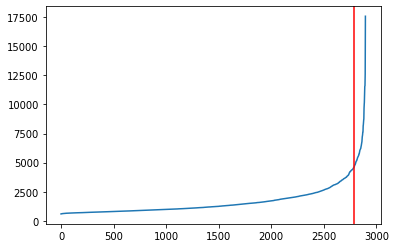

In [33]:
neighbors = NearestNeighbors(n_neighbors=90)
neighbors_fit = neighbors.fit(df2)
distances, _ = neighbors_fit.kneighbors(df2)
distances = np.sort(distances, axis=0)
distances = distances[:,89]
plt.plot(distances)
kl = KneeLocator(x=range(df2.shape[0]),y=distances,direction='increasing',curve='convex')
elbow = kl.elbow
plt.axvline(x=elbow, ymin=0, ymax = max(distances), color='red')
print('The elbow occurs at',distances[elbow])


The epsilon suggested is 4554.

In [34]:
db = DBSCAN(eps=4554, min_samples=51)

In [35]:
preds = db.fit_predict(df2)

In [36]:
sum(preds==-1)

21

According to DBSCAN there are 21 outliers

In [37]:
outliers1 = df2[preds==-1].index
outliers1

Int64Index([ 1750,  2602,  4008,  5056,  7053,  7399,  7492,  7710,  7781,
             8594, 10038, 10302, 10490, 10953, 11334, 12563, 14391, 14773,
            15749, 15780, 15835],
           dtype='int64')

## Using Local Outlier Factor

In [38]:
lof = LocalOutlierFactor()

In [39]:
preds2 = lof.fit_predict(df2)
outliers2 = df2[preds2==-1].index
outliers2

Int64Index([  284,   343,   507,   513,   525,   921,   965,  1319,  1493,
             1749,  1750,  1966,  2026,  2151,  2947,  3056,  3094,  3694,
             3822,  3829,  4128,  4132,  4496,  4500,  4542,  4580,  4590,
             4829,  5389,  5489,  5502,  5763,  5841,  5885,  5894,  5896,
             6020,  6100,  6681,  7066,  7318,  7664,  7710,  7858,  7931,
             7967,  8073,  8163,  8183,  8429,  9146,  9190,  9366,  9513,
            10069, 10476, 10490, 10502, 10699, 10764, 10867, 11662, 11777,
            12549, 12733, 12815, 12932, 12940, 13454, 13544, 14036, 14261,
            14315, 14931, 15356, 15670, 15749, 15780, 15875, 15977, 16101],
           dtype='int64')

Local Outlier Factor predicted many more outliers

## Using 3 IQR for numeric variables to find consistent outliers.

In [40]:
outliers = {}
for column in df.columns:
    description = df[column].describe()
    q1 = description['25%']
    q3 = description['75%']
    iqr15 = 3*(q3-q1)
    indices = df[(df[column]<q1-iqr15)|(df[column]>q3+iqr15)].index
    for x in indices:
        outliers[x]=outliers.get(x,0)+1
outlier_df=pd.DataFrame({'index':outliers.keys(),'count':outliers.values()})
outliers3 = (outlier_df.sort_values(by='count',ascending=False).head(30))['index']
outliers3 = np.array(list(outliers3))
outliers3

array([15007, 15835, 10953,  9748,  1750,   178, 10038, 14391,  7710,
       14236, 10302,  2943, 16166,  7492, 11226,  4844,  8594,  9897,
        4662,   475, 14773, 14239,  3112,  9041,  7010,  3709, 16182,
       11771,  7539, 15162])

In [41]:
outliers_all3 = set(outliers1).intersection(set(outliers2).intersection(set(outliers3)))
outliers_all3

{1750, 7710}

2 values were found to be an outlier in all 3 methods.  These I am going to drop.  The rest of the outliers found in both DBSCAN and LOF I am going to mark as outliers.

In [42]:
for i in np.intersect1d(outliers1,outliers2):
    df.loc[df.index==i,'outlier']=1

In [43]:
df.drop(outliers_all3,inplace=True)

# EDA

### Dependant variable -- LBXTC

<AxesSubplot:>

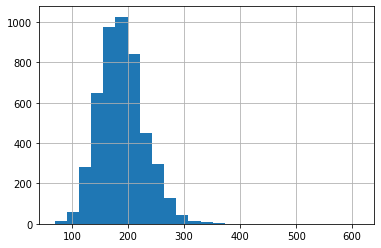

In [44]:
df.LBXTC.hist(bins=25)

The distribution is skewed.  There do appear to be outliers. As there are not many predictions above 350, it may make it hard to predict values in that range.  
I am going to log transform the variable

In [45]:
df['log_LBXTC']=np.log(df.LBXTC)

### Histograms of continuous variables

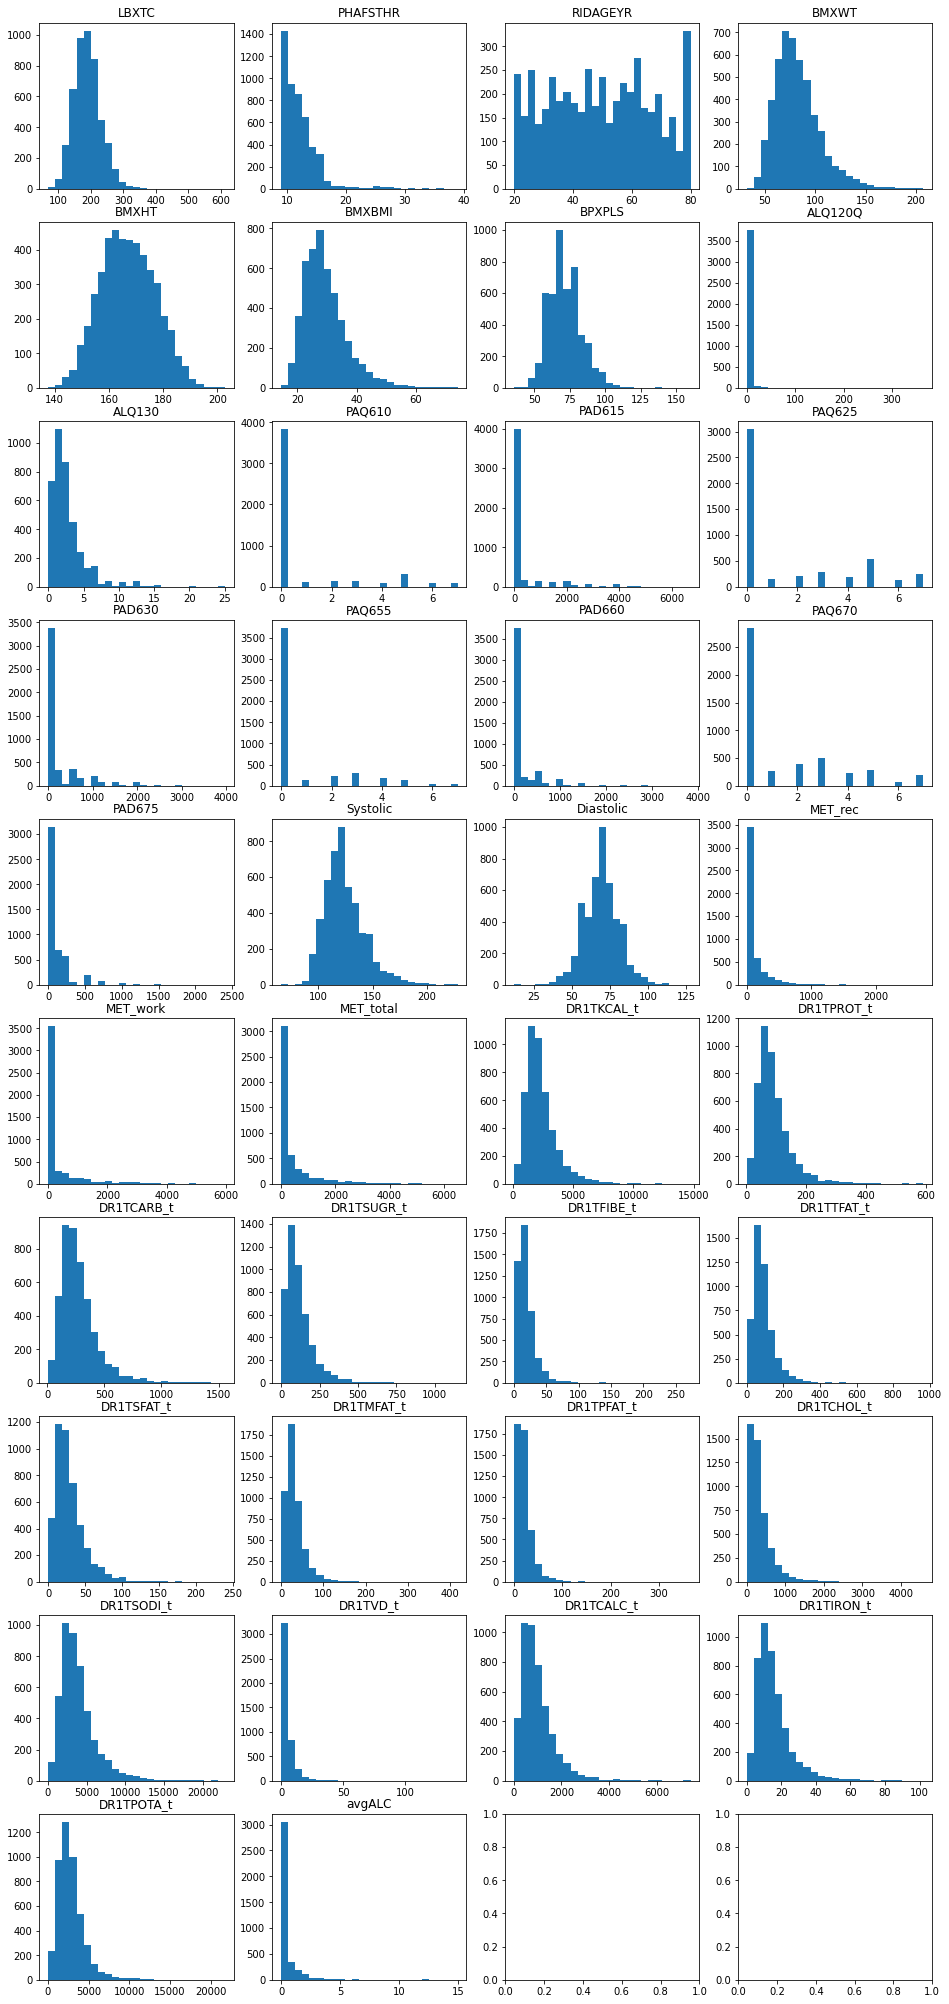

In [53]:
r,c = (0,0)
fig, axs = plt.subplots(10,4,figsize=[16,36])
for f in numerical_variables:
    axs[r,c].hist(df[f], bins=25)
    axs[r,c].set_title(f)
    c = c+1
    if c >= 4:
        r = r+1
    c = c % 4

Many distributions appear skewed.  It may help to log transform the variables.  For the same variables I am looking at boxplots.

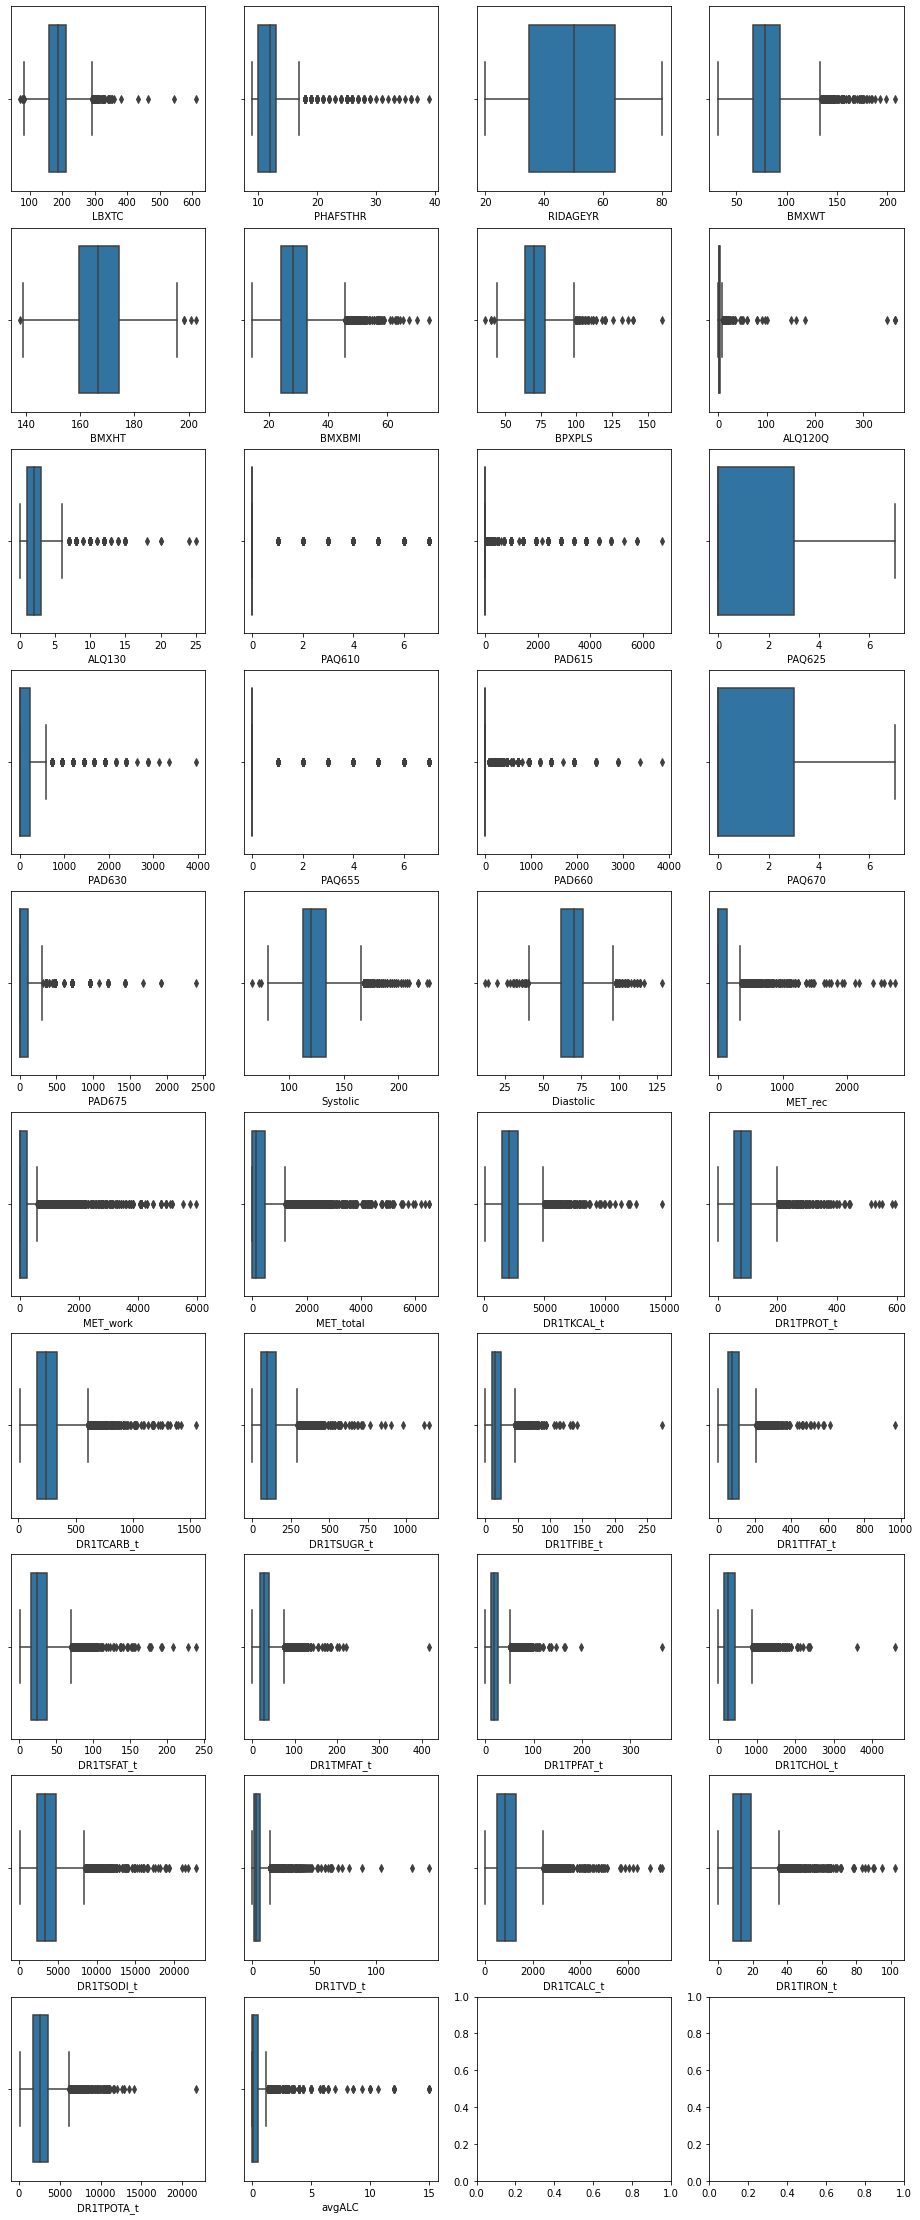

In [62]:
r,c = (0,0)
fig, axs = plt.subplots(10,4,figsize=[16,40])
for f in numerical_variables:
    sns.boxplot(x=df[f],ax=axs[r,c])
    c = c+1
    if c >= 4:
        r = r+1
        c = c % 4

As can be seen, there are many outliers.  When working with linear models, I may want to winsorize

### Correlation between variables

<AxesSubplot:>

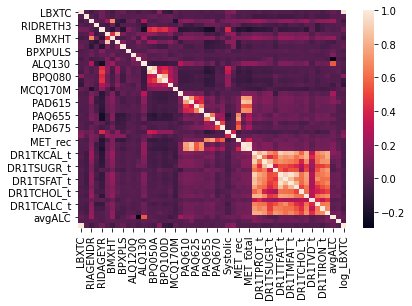

In [63]:
sns.heatmap(df.corr())

There definitely appears to be correlation between nutrition variables.  I may want to use PCA at least for linear models.

Looking at correlation between variables and log_LBXTC, the log of the total cholesterol level.  Taking the absolute values so that I can look at the strength of correlation.

In [65]:
np.abs(df.corr()['log_LBXTC']).sort_values(ascending=False)

log_LBXTC     1.000000
LBXTC         0.983394
Diastolic     0.155776
BPQ080        0.143596
DIQ010        0.129889
BPQ100D       0.097683
Systolic      0.096704
RIDAGEYR      0.078749
BMXHT         0.074319
RIAGENDR      0.071505
BPQ050A       0.056523
DR1TIRON_t    0.047028
ALQ120U       0.046593
BPXPLS        0.045525
DR1TCARB_t    0.043235
MCQ170M       0.036497
avgALC        0.036329
DR1TSODI_t    0.036167
DR1TPFAT_t    0.035538
DR1TSUGR_t    0.032489
PAD630        0.031179
BPQ020        0.029563
BPXPULS       0.029399
DR1TKCAL_t    0.028542
PAD660        0.027862
DR1TTFAT_t    0.026290
SMQ681        0.025541
MET_total     0.024976
DR1TCALC_t    0.024331
MET_work      0.020541
MET_rec       0.020368
PAQ625        0.020227
DR1TMFAT_t    0.019976
DR1TSFAT_t    0.019715
PAD615        0.017684
DR1TCHOL_t    0.016126
BMXBMI        0.015683
BMXWT         0.013852
DR1TPROT_t    0.013224
DR1TVD_t      0.012619
PHAFSTHR      0.010460
RIDRETH3      0.010213
PAQ655        0.008198
PAD675     

Blood pressure appears the most correlated however no variable is strongly correlated.  Linear models may be difficult.